# Generating Stress/Strain data using Integration

The following mathematical methods I do not fully understand, but I am going to use the equations from the DeepMod paper anyway and code them into python to see the results.

## Developing the code in notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import VE_DataGen_Functions as vedg
import torch

from deepymod_torch.library_function import *
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import train_group, deepmod_init, train_group_mse
from deepymod_torch.sparsity import scaling, threshold
from deepymod_torch.utilities import terms_definition

try:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
except:
    pass

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## After moving functionality to .py, testing functions

In [7]:
Input_Type = 'Stress'
E = [1, 1, 1]
Eta = [2.5, 1.25] #Remy uses Tau as input. Eta = E*Tau, and all the Es are 1, so Eta = Tau
t = sp.symbols('t', real=True)
Input_Function = sp.sinc(t)
Input_Description = 'Sinc'
Int_Type = 'Numerical'

# Returns a tuple if Int_Type = 'Numerical', where the first element is an analytical expression and the second is a function for integrating numerically a second term.
# Returns a single expression if Int_Type = 'Analytical'. Note, this may not be computationally possible.
Tuple_of_Expressions = vedg.Stress_Strain_Master_Int(Input_Type, E, Eta, Input_Function, Int_Type, t)
print(Tuple_of_Expressions)

(3.0 - 1.0*exp(-0.8*t) - 1.0*exp(-0.4*t), <function Stress_Strain_Master_Int.<locals>.<lambda> at 0x7f1c882bd510>)


In [8]:
E0, E1, E2 = E
tau1, tau2 = Eta[0]/E[1], Eta[1]/E[2]

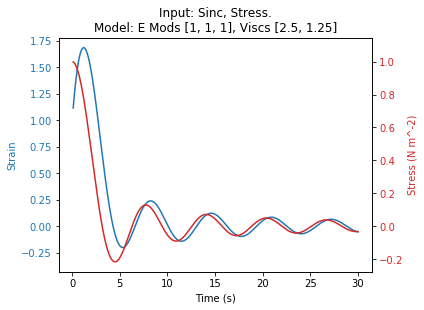

In [9]:
time = np.linspace(0.1, 30, 5000)

title = ('Input: ' + Input_Description + ', ' + Input_Type + 
         '.\nModel: E Mods ' + str(E) + ', Viscs ' + str(Eta))

Strain_Array, Stress_Array = vedg.Eval_Graph_Strain_Stress(title, time, Input_Function, Tuple_of_Expressions, Input_Type, Int_Type, t)

In [14]:
time[100]

0.6981196239247849

In [15]:
Strain_Array[100]

1.57232443729320

In [16]:
t_v = np.float32(np.expand_dims(time,axis=1))
y_stress = np.float32(np.expand_dims(Stress_Array,axis=1))
y_strain = np.float32(np.expand_dims(Strain_Array,axis=1))

Here we will transfer the numpy arrays into torch tensors

In [17]:
number_of_samples = 2000

idx = np.random.permutation(y_strain.size)
X_train = torch.tensor(t_v[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_strain[idx, :][:number_of_samples], dtype=torch.float32)

In [18]:
y_train.shape

torch.Size([2000, 1])

Here we set the parameters of DeepMoD

In [36]:
optim_config = {'lambda': 10**-6, 'max_iterations': 10001}

In [37]:
network_config = {'input_dim': 1, 'hidden_dim': 40, 'layers': 4, 'output_dim': y_train.shape[1]}

In [38]:
library_config = {'type': mech_library_group}

Here we initialize DeepMoD 

In [39]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

 Let's optimize the MSE before running the full optimization of DeepMoD 

In [40]:
train_group_mse(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 1.9E-01 1.9E-01
5000 8.9E-04 8.9E-04
10000 3.2E-05 3.2E-05


Let's run all the input data through the trained network 

In [42]:
t_all = torch.tensor(t_v, dtype=torch.float32, requires_grad=True) 
prediction_full = network(t_all)

Plot the prediction in blue and ground truth in orange

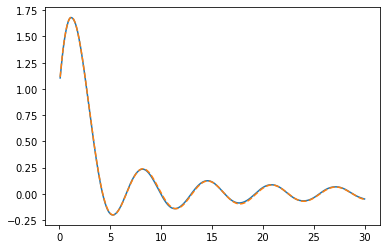

In [43]:
plt.plot(t_v,prediction_full[:,0].cpu().detach().numpy())
plt.plot(t_v,Strain_Array,'--')

Now run the full DeepMoD to obtain optimize the PI and MSE together

In [ ]:
time_deriv_list, theta, coeff_vector_list = train_group(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config) 

Epoch | Total loss | MSE | PI | L1 
0 3.5E-05 1.2E-05 1.3E-05 4.7E-06 4.7E-06
tensor([[0.5564],
        [1.2503],
        [1.8364],
        [0.0069],
        [0.3478],
        [1.4395],
        [0.7530]], requires_grad=True)


Calculate the scaled coefficient 

In [45]:
scaled_coeff_vector_list = [scaling(coeff_vector, theta, time_deriv) for coeff_vector, theta , time_deriv in zip(coeff_vector_list, theta, time_deriv_list)]

In [46]:
sparse_coeff_vector_list, sparsity_mask_list_final = zip(*[threshold(scaled_coeff_vector, coeff_vector) for scaled_coeff_vector, coeff_vector in zip(scaled_coeff_vector_list, coeff_vector_list)])

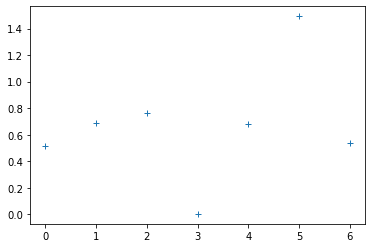

In [48]:
plt.plot(np.abs(scaled_coeff_vector_list[0].cpu().detach().numpy()),'+')
#plt.yscale('log')

In [63]:
sparsity_mask_list_final

(tensor([0, 1, 5]),)

In [61]:
# True Zener+1 coefficients
C0=1
C1=tau1+tau2
C2=tau1*tau2
C3=E0
C4=tau1*tau2*(E0+E1+E2)

C0 = 1/(tau1*(E0+E1)+tau2*(E0+E2))
C1 = C1/(tau1*(E0+E1)+tau2*(E0+E2))
C2 = C2/(tau1*(E0+E1)+tau2*(E0+E2))
C3 = C3/(tau1*(E0+E1)+tau2*(E0+E2))
C4 = C4/(tau1*(E0+E1)+tau2*(E0+E2))

print(C0,C1,C2,C3,C4)

0.08333333333333333 0.5 0.4166666666666667 0.08333333333333333 1.25


In [62]:
coeff_vector_list

[tensor([[ 5.7265e-01],
         [ 1.8610e+00],
         [ 5.9454e-01],
         [-3.5401e-05],
         [ 1.8701e-01],
         [ 6.7529e-01],
         [ 7.4717e-03]], requires_grad=True)]

In [67]:
coeff_vector_list[0][1]/coeff_vector_list[0][0]

tensor([3.2498], grad_fn=<DivBackward0>)

In [68]:
coeff_vector_list[0][2]/coeff_vector_list[0][1]

tensor([0.3195], grad_fn=<DivBackward0>)